#Assignment 3.2: LSTM ASSIGNMENT

This assignment is aimed at implementing LSTMs that we had learnt in class. In this task, we'll implement a model that takes text data as input and returns the emotion behind the text.

## TEXT PRE-PROCESSING FOR NLP

**Import the dataset.**

In [41]:
import pandas as pd
df = pd.read_csv("/content/new_dataset.csv")
df.head()


,sentiment,text
0,Negative,@xnausikaax oh no! where did u order from? tha...
1,Negative,A great hard training weekend is over. a coup...
2,Negative,"Right, off to work Only 5 hours to go until I..."
3,Negative,I am craving for japanese food
4,Negative,Jean Michel Jarre concert tomorrow gotta work...


**The dataset clearly has a large no. of redundant words, because that is simply how we humans talk. We'll first remove the stopwords.**


In [43]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tokenizer = RegexpTokenizer(r'\w+')

def remove_stopwords_regex(text):
    tokens = tokenizer.tokenize(text.lower())
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['text'] = df['text'].apply(remove_stopwords_regex)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentiment,text
0,Negative,xnausikaax oh u order horrible
1,Negative,great hard training weekend couple days rest l...
2,Negative,right work 5 hours go free xd
3,Negative,craving japanese food
4,Negative,jean michel jarre concert tomorrow gotta work ...


**Now, we'll perform stemming, wherein we'll reduce the words to their root form.**

In [44]:
from nltk.stem import PorterStemmer

nltk.download('stopwords')
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def apply_stemming_simple(text):
    words = text.split()  # Simple space-based tokenization
    stemmed = [stemmer.stem(word.strip('.,!?').lower())  # Remove punctuation manually
               for word in words if word.lower() not in stop_words]
    return ' '.join(stemmed)

df['text'] = df['text'].apply(apply_stemming_simple)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,sentiment,text
0,Negative,xnausikaax oh u order horribl
1,Negative,great hard train weekend coupl day rest let lo...
2,Negative,right work 5 hour go free xd
3,Negative,crave japanes food
4,Negative,jean michel jarr concert tomorrow gotta work 7...


**Now that we are done with pre-processing, lets see what the gist of the data is that our model should capture.**
**Generate a word-cloud for the positive and negative words of the dataset.**

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


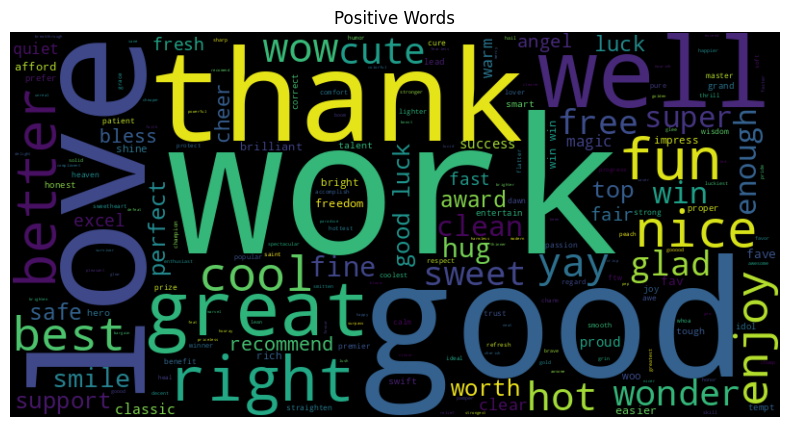

In [47]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

positive_words = set(opinion_lexicon.positive())

def get_positive_words(text):
    words = text.lower().split()
    return ' '.join(word.strip('.,!?') for word in words if word.strip('.,!?') in positive_words)

df['positive_only'] = df['text'].apply(get_positive_words)

all_positive_text = ' '.join(df['positive_only'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Words')
plt.show()


[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


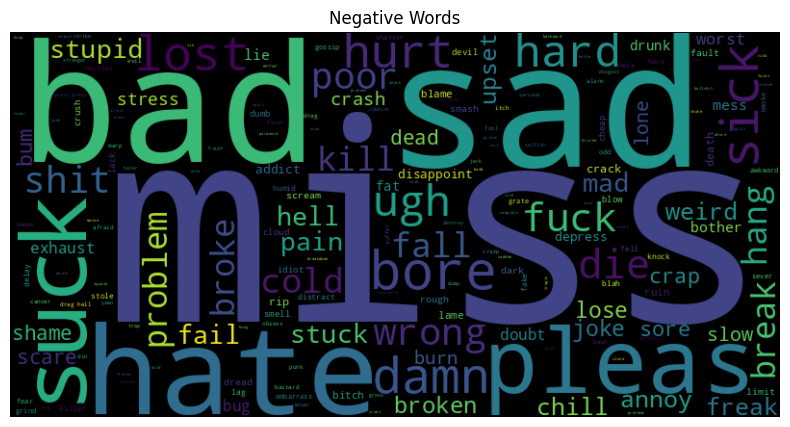

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

nltk.download('opinion_lexicon')
from nltk.corpus import opinion_lexicon

negative_words = set(opinion_lexicon.negative())

def get_negative_words(text):
    words = text.lower().split()
    return ' '.join(word.strip('.,!?') for word in words if word.strip('.,!?') in negative_words)

df['negative_only'] = df['text'].apply(get_negative_words)

all_negative_text = ' '.join(df['negative_only'])

wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Words')
plt.show()


## TRAINING

**We have now processed the data for training. It's time for us to split it into training and test splits.**

In [50]:
from sklearn.model_selection import train_test_split


# Split into 90% train and 10% test
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)



**It is now time to convert our text sequences into numbers like the model will understand. Fit a tokenizer on the training dataset for the same. Let the vocab size be the no of unique words itself.**

In [52]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")  # download with: python -m spacy download en_core_web_sm
all_tokens = []

for doc in nlp.pipe(train_df['text']):
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    all_tokens.extend(tokens)

word_freq = Counter(all_tokens)
vocab = {word: idx+1 for idx, (word, _) in enumerate(word_freq.items())}  # idx+1 to reserve 0
vocab_size = len(vocab)

print(f"Vocab size: {vocab_size}")


Vocab size: 13079


**Now transform the training and testing word sequences.**

In [54]:
def text_to_sequence(text, vocab):
    # Use spacy for tokenization and filtering, similar to the previous cell
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    return [vocab[token] for token in tokens if token in vocab]

train_sequences = [text_to_sequence(text, vocab) for text in train_df['text']]
test_sequences = [text_to_sequence(text, vocab) for text in test_df['text']]

# Output
print("Train sequences (first example):", train_sequences[0])
print("Test sequences (first example):", test_sequences[0])

Train sequences (first example): [1, 2, 3, 4, 5, 4, 6, 7, 8, 9]
Test sequences (first example): [764, 1948, 6434, 6786, 416, 158]


**It is necessary for the simplicity of the model that each text sequence be of the same length. Pad the sequences to make this possible.**

In [60]:
import numpy as np

def pad_sequences(sequences, maxlen, padding_value=0):
    padded_seqs = []
    for seq in sequences:
        if len(seq) < maxlen:
            # pad with padding_value at the end
            padded_seq = seq + [padding_value] * (maxlen - len(seq))
        else:
            # truncate if longer than maxlen
            padded_seq = seq[:maxlen]
        padded_seqs.append(padded_seq)
    return np.array(padded_seqs)

# Define max sequence length (e.g. max length in training)
max_len = max(len(seq) for seq in train_sequences)

# Pad sequences
train_padded = pad_sequences(train_sequences, max_len)
test_padded = pad_sequences(test_sequences, max_len)

print("Padded training\n", train_padded[0])
print("Padded testing\n", test_padded[0])

Padded training
 [1 2 3 4 5 4 6 7 8 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Padded testing
 [ 764 1948 6434 6786  416  158    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


**Label encode y.**

In [65]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd


le = LabelEncoder()


le.fit(train_df['sentiment'])

# Transform train and test labels
y_train_encoded = le.transform(train_df['sentiment'])
y_test_encoded = le.transform(test_df['sentiment'])


print("Encoded train labels:", y_train_encoded)

print("Encoded test labels:", y_test_encoded)


Encoded train labels: [0 0 0 ... 1 0 1]
Encoded test labels: [1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 0 0 1 0 1
 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0
 0 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1
 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0
 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 0 1 0
 0 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1
 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 0
 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 

**FOLLOWING CODE IS FOR CREATING WORD EMBEDDINGS. DON'T TOUCH IT.JUST REPLACE VOCAB_SIZE WITH THE VOCABULARY SIZE OBTAINED EARLIER.**

In [73]:
import tensorflow as tf
import numpy as np
!wget --no-check-certificate http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-16 20:04:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-16 20:04:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-16 20:04:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zi

In [83]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../content/best_model.hdf5'
embeddings_index = {}
f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' %len(embeddings_index))

# Create word_index from the existing vocab
word_index = {word: index for index, word in enumerate(vocab)}

# Recalculate vocab_size based on the actual vocabulary
vocab_size = len(vocab)

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))


for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

embedding_layer = tf.keras.layers.Embedding(vocab_size,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len,trainable=False)

Found 400000 word vectors.


![Sequence Model](https://miro.medium.com/max/1458/1*SICYykT7ybua1gVJDNlajw.png)

**You should read up on why we added the previou code block.The embedding layer created is to be used in the model. Use the model summary to build the rest. Compile the model with Adam and a suitable loss function.**

In [92]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np

sequence_input = Input(shape=(max_len,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)


# Start model from embedding
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(128, kernel_size=5, activation='relu')(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)

# For binary classification, use 1 output unit with sigmoid activation
# num_classes is 2, so we use binary classification setup
output = Dense(1, activation='sigmoid')(x)

# Create and compile the model
model = Model(inputs=sequence_input, outputs=output)
model.compile(
    loss='binary_crossentropy', # Binary crossentropy for binary classification
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 70, 300)        │     4,431,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ (None, 70, 300)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 66, 128)        │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,722,673 (18.02 MB)

 Trainable params: 291,073 (1.11 MB)

 Non-trainable params: 4,431,600 (16.91 MB)

**Train the model on the train split, and validate it on the test split.**

In [93]:
# No need for to_categorical with single output unit and binary_crossentropy

history = model.fit(
    train_padded,
    y_train_encoded, # Use the original encoded labels
    validation_data=(test_padded, y_test_encoded), # Use the original encoded labels
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 53s 161ms/step - accuracy: 0.5213 - loss: 0.7121 - val_accuracy: 0.6140 - val_loss: 0.6545
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 45s 158ms/step - accuracy: 0.6375 - loss: 0.6372 - val_accuracy: 0.6370 - val_loss: 0.6388
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.6899 - loss: 0.5801 - val_accuracy: 0.6350 - val_loss: 0.6344
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 45s 157ms/step - accuracy: 0.7516 - loss: 0.5085 - val_accuracy: 0.6080 - val_loss: 0.6685
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 81s 156ms/step - accuracy: 0.8129 - loss: 0.4123 - val_accuracy: 0.6380 - val_loss: 0.6950
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 157ms/step - accuracy: 0.8694 - loss: 0.3014 - val_accuracy: 0.6540 - val_loss: 0.7625
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 83s 162ms/step - accuracy: 0.8949 - loss: 0.2542 - val_accuracy: 0.6430 - val_loss: 0.8810
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 82s 162ms/step - accuracy: 0.9191 - loss: 0

**Let's visualise the model's training history now.**

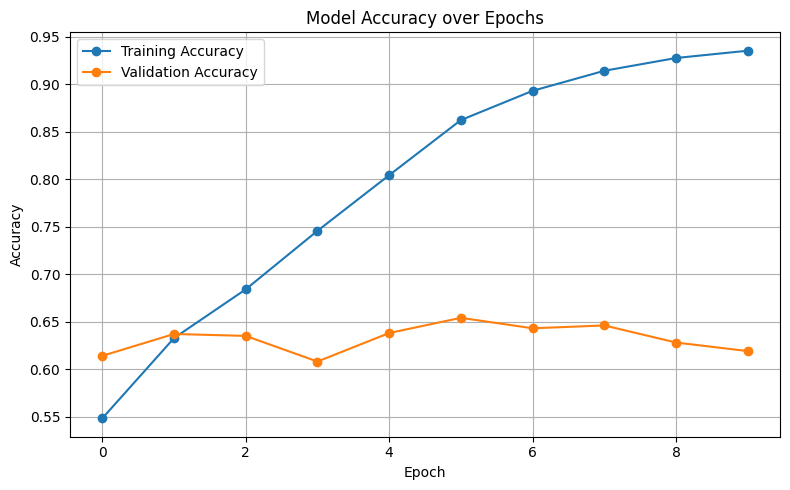

In [94]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Lets see what the accuracy of the model is.**

In [97]:
loss, accuracy = model.evaluate(test_padded, y_test_encoded, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.6190


## GOOD JOB!